In [2]:
import os
!pip install hdbscan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
import hdbscan


drive.mount('/content/drive')
data_directory = '/content/drive/My Drive/data'
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.txt')]

all_data = []
for file_path in all_files:
    data = []
    hist = []
    with open(file_path, 'r') as file:
        skip_header = True
        for line in file:
            if skip_header:
                skip_header = False
                continue
            parts = line.split()
            if len(parts) == 3:
                if hist:
                    data.append(hist)
                hist = [int(x) for x in parts]
            else:
                hist.extend(map(int, parts))
    if hist:
        data.append(hist)

    cols = ['year', 'day', 'hour'] + [f'bin_{i+1}' for i in range(60)]
    df = pd.DataFrame(data, columns=cols)
    all_data.append(df)

full_data = pd.concat(all_data, ignore_index=True)

he3_start = int((2.7 - 2) / 0.05)
he3_end = int((3.3 - 2) / 0.05)
he4_start = int((3.7 - 2) / 0.05)
he4_end = int((4.3 - 2) / 0.05)
full_data['He-3'] = full_data.iloc[:, 3+he3_start:3+he3_end+1].sum(axis=1)
full_data['He-4'] = full_data.iloc[:, 3+he4_start:3+he4_end+1].sum(axis=1)
full_data['He-3 Rich'] = ((full_data['He-3'] >= 0.5 * full_data['He-4']) & ((full_data['He-3'] + full_data['He-4']) >= 20)).astype(int)


Mounted at /content/drive


In [3]:
print("columns:")
print(full_data.columns)
print("\nrows:")
print(full_data.head(2))
print("\ncolumn stats")
print(full_data.groupby('He-3 Rich').describe().transpose())

columns:
Index(['year', 'day', 'hour', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5',
       'bin_6', 'bin_7', 'bin_8', 'bin_9', 'bin_10', 'bin_11', 'bin_12',
       'bin_13', 'bin_14', 'bin_15', 'bin_16', 'bin_17', 'bin_18', 'bin_19',
       'bin_20', 'bin_21', 'bin_22', 'bin_23', 'bin_24', 'bin_25', 'bin_26',
       'bin_27', 'bin_28', 'bin_29', 'bin_30', 'bin_31', 'bin_32', 'bin_33',
       'bin_34', 'bin_35', 'bin_36', 'bin_37', 'bin_38', 'bin_39', 'bin_40',
       'bin_41', 'bin_42', 'bin_43', 'bin_44', 'bin_45', 'bin_46', 'bin_47',
       'bin_48', 'bin_49', 'bin_50', 'bin_51', 'bin_52', 'bin_53', 'bin_54',
       'bin_55', 'bin_56', 'bin_57', 'bin_58', 'bin_59', 'bin_60', 'He-3',
       'He-4', 'He-3 Rich'],
      dtype='object')

rows:
   year  day  hour  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  ...  \
0  2016  280     0      0      0      0      0      0      0      0  ...   
1  2016  280     1      0      0      0      0      0      0      0  ...   

   bin_54  bin_55  

In [4]:
X = full_data[['He-3', 'He-4']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(X_scaled)
full_data['Cluster_Labels'] = cluster_labels


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Cluster_Labels
304    20831
284    19128
305    17347
260    14684
262    10670
       ...  
28         5
61         5
105        5
514        5
197        5
Name: count, Length: 1146, dtype: int64


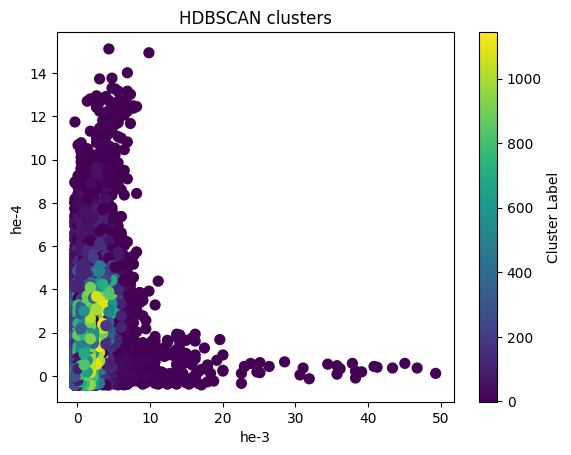

In [8]:
import matplotlib.pyplot as plt

# Kmeans vs dbscan - why kmeans is bad - fixed number of clusters and noisy
# how to determine quality of results - silouhette coefficients
# hdbscan  better - no epsilon or number of clusters
# combine clustering with ml approach

print(full_data['Cluster_Labels'].value_counts())

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('HDBSCAN clusters')
plt.xlabel('he-3')
plt.ylabel('he-4')
plt.colorbar(label='Cluster Label')
plt.show()

#quiet time data - green


In [9]:
cluster_summary = full_data['Cluster_Labels'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_summary)

cluster_stats = full_data.groupby('Cluster_Labels')[['He-3', 'He-4']].describe()
print("Cluster Statistics:")
print(cluster_stats)

Cluster Sizes:
Cluster_Labels
-1       1022
 0         11
 1          8
 2          7
 3          8
         ... 
 1140       9
 1141       6
 1142       7
 1143      10
 1144       5
Name: count, Length: 1146, dtype: int64
Cluster Statistics:
                  He-3                                                         \
                 count       mean        std   min    25%   50%    75%    max   
Cluster_Labels                                                                  
-1              1022.0  10.882583  10.464338   0.0   6.00   9.0  13.00  117.0   
 0                11.0  88.545455   6.532437  76.0  85.00  90.0  92.00   98.0   
 1                 8.0  56.750000   2.604940  54.0  54.75  56.0  59.25   60.0   
 2                 7.0  21.571429   0.534522  21.0  21.00  22.0  22.00   22.0   
 3                 8.0  38.750000   1.035098  37.0  38.00  39.0  39.25   40.0   
...                ...        ...        ...   ...    ...   ...    ...    ...   
 1140              9.0   8.